In [1]:
pip install keras==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

2024-06-04 14:52:24.589003: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 14:52:24.589105: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 14:52:24.702686: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0
2.15.0


In [3]:
# Importing dependencies

import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import *
import keras
from tensorflow.keras.callbacks import Callback

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score,RocCurveDisplay

SEED = 42
IMG_SIZE = 224, 224
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE

In [4]:
# creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    for i in images:
        full_path.append(os.path.join(path, i))
    return full_path


classes = {0: 'Benign', 1: 'Malignant'}

train_benign_imgs = create_images_list('/kaggle/input/melanoma-cancer-dataset/train/Benign')
train_malignant_imgs = create_images_list('/kaggle/input/melanoma-cancer-dataset/train/Malignant')

full_data = pd.concat([pd.DataFrame({'image' : train_benign_imgs, 'label': 0 }),
                      pd.DataFrame({'image' : train_malignant_imgs, 'label': 1 })])
# shuffling dataset
full_data = full_data.sample(frac = 1, ignore_index = True, random_state = SEED)

# train and valid splitting
train_data, valid_data = train_test_split(full_data, test_size = 0.2, stratify = full_data['label'])

train_data = train_data.reset_index(drop = True)
valid_data = valid_data.reset_index(drop = True)

# test dataframe
test_benign_imgs = create_images_list('/kaggle/input/melanoma-cancer-dataset/test/Benign')
test_malignant_imgs = create_images_list('/kaggle/input/melanoma-cancer-dataset/test/Malignant')

test_data = pd.concat([pd.DataFrame({'image' : test_benign_imgs, 'label': 0 }),
                       pd.DataFrame({'image' : test_malignant_imgs, 'label': 1 })])
test_data = test_data.sample(frac = 1, ignore_index = True, random_state = SEED)


print('total train images \t{0}'.format(train_data.shape[0]))
print('total valid images \t{0}'.format(valid_data.shape[0]))
print('total test images \t{0}'.format(test_data.shape[0]))

total train images 	9503
total valid images 	2376
total test images 	2000


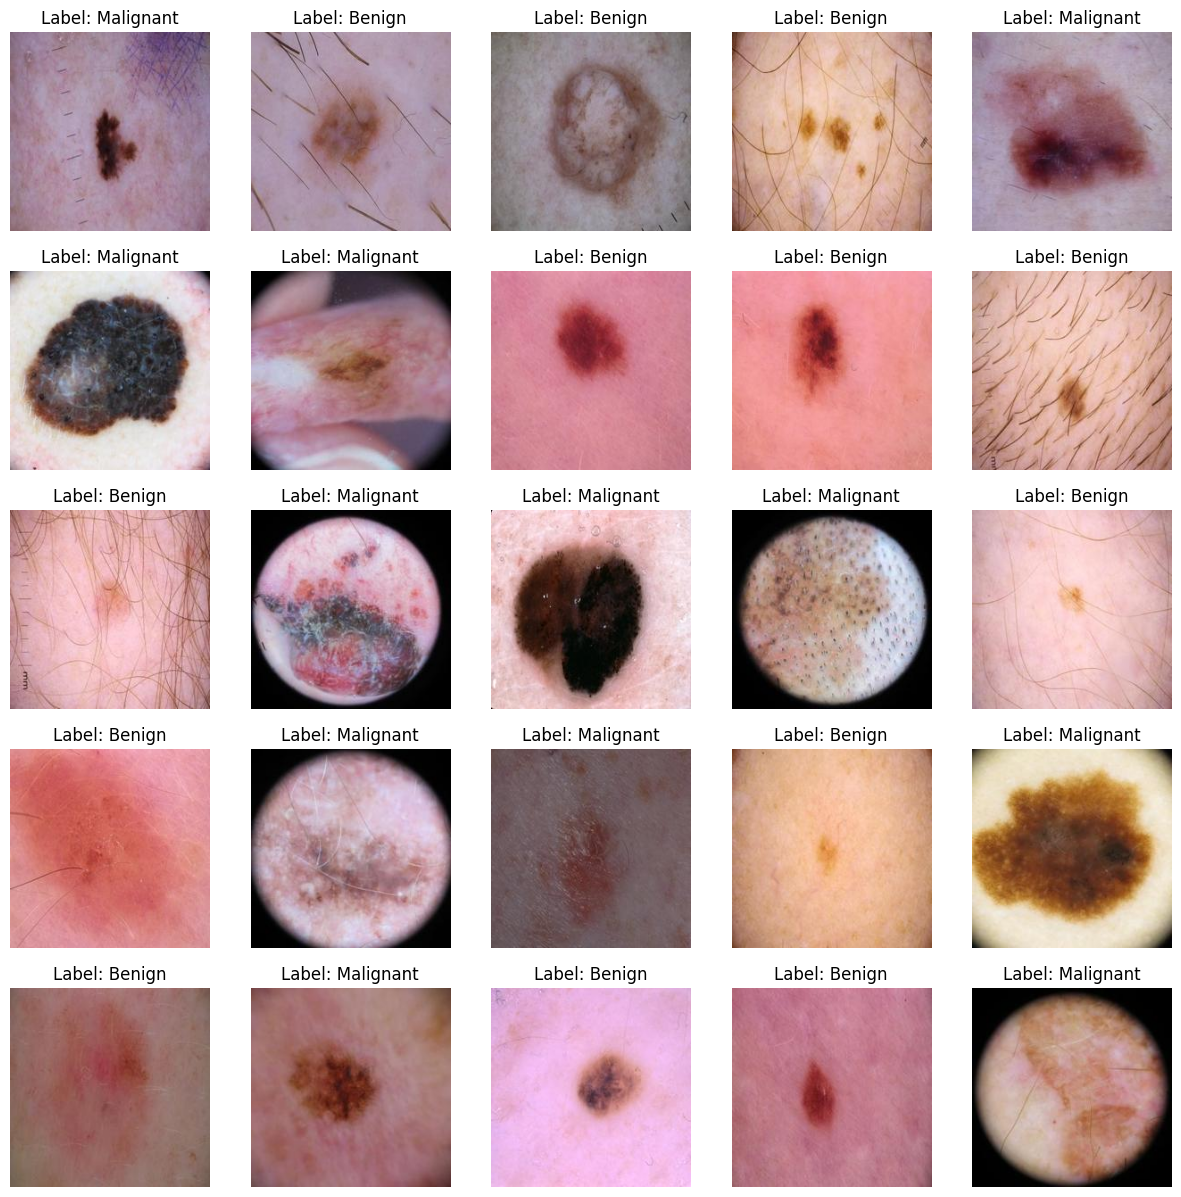

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Print 25 random samples from the training data with inferno colormap
plt.figure(figsize=(15, 15))

for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    random_index = np.random.randint(0, train_data.shape[0])
    img_path = train_data.loc[random_index, 'image']
    img = Image.open(img_path)
    plt.imshow(img)
    ax.set_title(f"Label: {classes[train_data.loc[random_index, 'label']]}")
    ax.axis('off')

plt.show()

In [6]:
# Reading -> Resizing -> Normalization
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_png(img, channels = 3)
    img = tf.image.resize(img, size =(IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0


    return img, label


# Data augmentation
img_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation((-0.3, 0.3), interpolation="bilinear"),
    RandomContrast(0.03),
    RandomCrop(*IMG_SIZE)])

In [7]:
# Creating dataset loaders and tf.datasets

train_loader = tf.data.Dataset.from_tensor_slices((train_data['image'], train_data['label']))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE*10)
                 .batch(BATCH_SIZE)
                 .map(lambda img, label: (img_augmentation(img), label), num_parallel_calls =AUTO)
                 .prefetch(AUTO))


valid_loader = tf.data.Dataset.from_tensor_slices((valid_data['image'], valid_data['label']))
valid_dataset = (valid_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))

test_loader = tf.data.Dataset.from_tensor_slices((test_data['image'], test_data['label']))
test_dataset = (test_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))

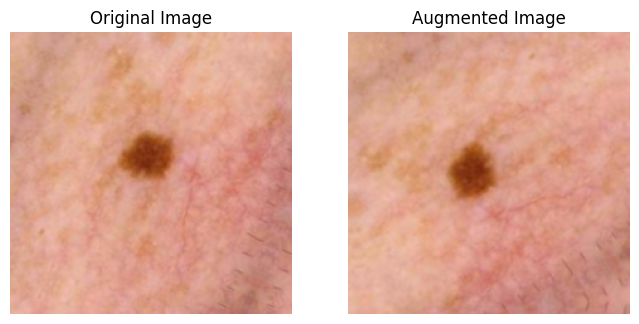

In [8]:
# Display original and augmented image for the first sample
def display_sample_images(dataset):
    for images, labels in dataset.take(1):
        # Display original image
        original_image = images[0].numpy()
        
        # Apply augmentation
        augmented_image = img_augmentation(images[0:1], training=True)[0].numpy()
        
        # Plotting
        plt.figure(figsize=(8, 4))
        
        # Original image
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(original_image,cmap='inferno')
        plt.axis("off")
        
        # Augmented image
        plt.subplot(1, 2, 2)
        plt.title("Augmented Image")
        plt.imshow(augmented_image,cmap='inferno')
        plt.axis("off")
        
        plt.show()
        break

# Display original and augmented images from train dataset
display_sample_images(train_dataset)

In [9]:
# a custom callback for evaluation of test set during training each 10 loop
class Test_Pred_During_Training(Callback):

    def __init__(self, model):
        self._model = model

    def on_epoch_end(self, epochs, logs = None ):
        try:
            if (epochs+1) % 10 == 0:
                test_pred = self.model.predict(test_dataset, verbose = 0)
                test_pred = np.argmax(test_pred, axis = 1)

                mse = mean_squared_error(test_data['label'], test_pred)
                f1 = f1_score(test_data['label'], test_pred, average = 'weighted')
                acc = accuracy_score(test_data['label'], test_pred)

                print('\nMean Squared Error : {0:.5f}'.format(mse))
                print('Weighted F1 Score : {0:.3f}'.format(f1))
                print('Accuracy Score : {0:.3f} %'.format(acc*100))

                print("--"*40)
        except ValueError:
            pass

In [10]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential

In [11]:
model = Sequential()
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.build(input_shape=(None, 224, 224, 3))


24274472/24274472 [==============================] - 0s 0us/step


In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                    metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 2)                

In [14]:
my_callbacks = [Test_Pred_During_Training(model=model),
                tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',factor=0.1, min_delta = 0.01, patience=6),
#                 tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.01,patience=20),
                tf.keras.callbacks.ModelCheckpoint("/kaggle/working/my_model.tf", monitor="val_loss", mode="min", save_best_only=True, verbose=1)]

In [15]:
import time
start = time.time()
history = model.fit(
    train_dataset,
    batch_size=32,
    epochs=50,
    validation_data=valid_dataset,
    callbacks=[my_callbacks]
)
print("Total time: ", time.time() - start, "seconds")

Epoch 1/50


2024-06-04 14:53:10.151546: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnetv2-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1717512795.276859      79 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


297/297 [==============================] - ETA: 0s - loss: 0.3672 - accuracy: 0.8392
Epoch 1: val_loss improved from inf to 3.62618, saving model to /kaggle/working/my_model.tf
297/297 [==============================] - 130s 288ms/step - loss: 0.3672 - accuracy: 0.8392 - val_loss: 3.6262 - val_accuracy: 0.5295 - lr: 0.0010
Epoch 2/50
297/297 [==============================] - ETA: 0s - loss: 0.2951 - accuracy: 0.8739
Epoch 2: val_loss improved from 3.62618 to 1.89114, saving model to /kaggle/working/my_model.tf
297/297 [==============================] - 78s 263ms/step - loss: 0.2951 - accuracy: 0.8739 - val_loss: 1.8911 - val_accuracy: 0.5295 - lr: 0.0010
Epoch 3/50
297/297 [==============================] - ETA: 0s - loss: 0.2772 - accuracy: 0.8827
Epoch 3: val_loss improved from 1.89114 to 0.60032, saving model to /kaggle/working/my_model.tf
297/297 [==============================] - 79s 265ms/step - loss: 0.2772 - accuracy: 0.8827 - val_loss: 0.6003 - val_accuracy: 0.6907 - lr: 0.00

In [16]:
# Print training results
print("Training Results:")
print("Loss:", history.history['loss'][-1])
print("Accuracy:", history.history['accuracy'][-1])
print("Validation Loss:", history.history['val_loss'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])

Training Results:
Loss: 0.10110612958669662
Accuracy: 0.9590655565261841
Validation Loss: 0.23842297494411469
Validation Accuracy: 0.9137205481529236


Loss: Train Loss = 0.1011, Validation Loss = 0.2384


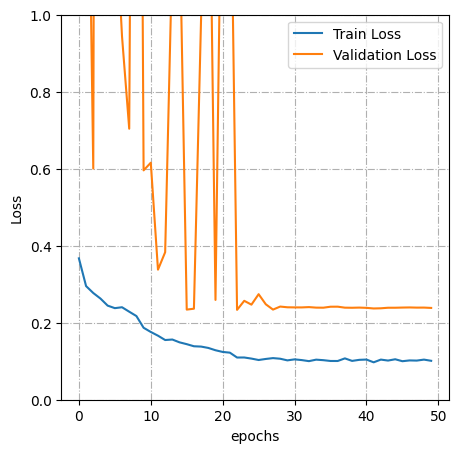

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5), dpi=100)

axs.grid(linestyle='dashdot')
axs.plot(history.history['loss'])
axs.plot(history.history['val_loss'])
axs.set_xlabel('epochs', fontsize=10)
axs.set_ylabel('Loss', fontsize=10)
axs.legend(['Train Loss', 'Validation Loss'], fontsize=10)
axs.set_ylim(0, 1)
print(f'Loss: Train Loss = {history.history["loss"][-1]:.4f}, Validation Loss = {history.history["val_loss"][-1]:.4f}')

Accuracy: Train Accuracy = 0.9591, Validation Accuracy = 0.9137


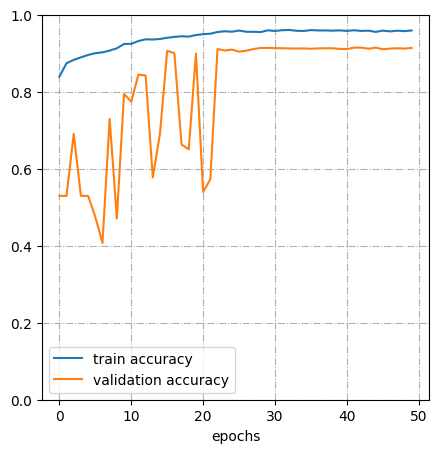

In [18]:
fig, axs = plt.subplots(1,1, figsize = (5, 5), dpi = 100)
axs.grid(linestyle = 'dashdot')
axs.plot(history.history['accuracy'])
axs.plot(history.history['val_accuracy'])
axs.set_xlabel('epochs', fontsize = 10)
axs.legend(['train accuracy', 'validation accuracy'], fontsize = 10)
axs.set_ylim(0, 1)
print(f'Accuracy: Train Accuracy = {history.history["accuracy"][-1]:.4f}, Validation Accuracy = {history.history["val_accuracy"][-1]:.4f}')

In [19]:
# Predictions and scores
test_pred = model.predict(test_dataset)
test_pred = np.argmax(test_pred, axis = 1)

mse = mean_squared_error(test_data['label'], test_pred)
f1 = f1_score(test_data['label'], test_pred, average = 'weighted')
acc = accuracy_score(test_data['label'], test_pred)

print('Mean Squared Error : {0:.5f}'.format(mse))
print('Weighted F1 Score : {0:.3f}'.format(f1))
print('Accuracy Score : {0:.3f} %'.format(acc*100))

63/63 [==============================] - 2s 27ms/step
Mean Squared Error : 0.07400
Weighted F1 Score : 0.926
Accuracy Score : 92.600 %


In [20]:
clf = classification_report(test_data['label'], test_pred, target_names = list(classes.values()))
print(clf)

              precision    recall  f1-score   support

      Benign       0.91      0.95      0.93      1000
   Malignant       0.95      0.90      0.92      1000

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



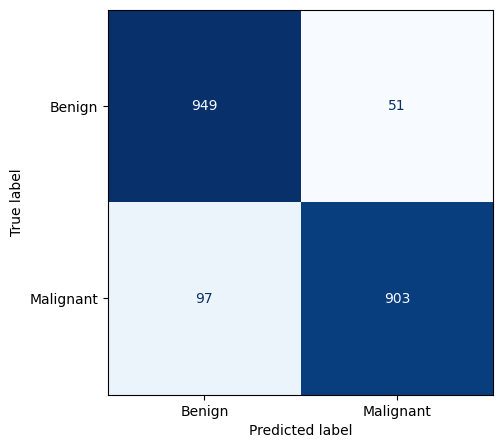

In [21]:
cm = confusion_matrix(test_data['label'], test_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels = list(classes.values()))

fig, ax = plt.subplots(figsize=(5,5))
cmd.plot(ax=ax,  cmap = 'Blues', colorbar = False)

In [22]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_dataset)

# Print test results
print("\nTest Results:")
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

63/63 [==============================] - 2s 30ms/step - loss: 0.2165 - accuracy: 0.9260

Test Results:
Test Loss: 0.2165001928806305
Test Accuracy: 0.9259999990463257


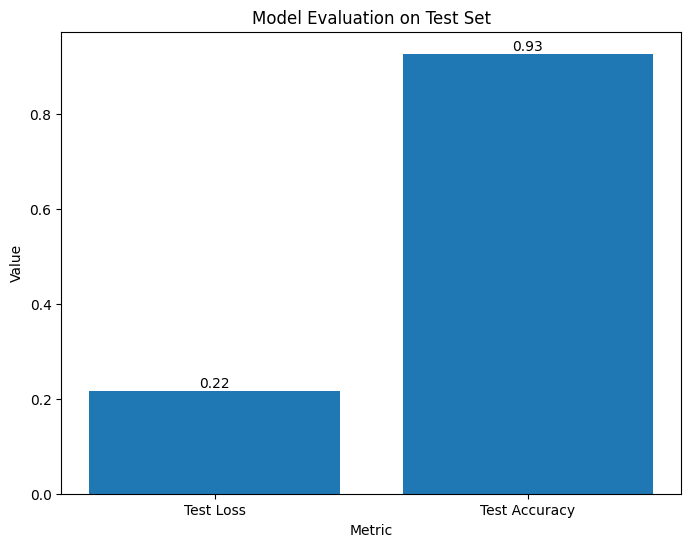

In [23]:
import matplotlib.pyplot as plt

# Create a bar chart
x = ['Test Loss', 'Test Accuracy']
y = [test_loss, test_acc]

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x, y)

# Add labels and title
ax.set_xlabel('Metric')
ax.set_ylabel('Value')
ax.set_title('Model Evaluation on Test Set')

# Add value labels to the bars
for i, v in enumerate(y):
    ax.text(i, v, f"{v:.2f}", ha='center', va='bottom', fontsize=10)

plt.show()

In [24]:
test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)

# A function that creating 5 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

def random_test_sample_with_prediction(SEED):
    idxs = np.random.default_rng(seed=SEED).permutation(len(test_pred))[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs - batch_idx * BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1, 5, figsize=(12, 12), dpi=150)

    for i in range(5):
        img = test_take1_[batch_idx[i]][0][image_idx[i]]
        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()
        pred = model.predict(tf.expand_dims(img, axis=0))[0]
        pred_label = np.argmax(pred)  # Lấy nhãn dự đoán có xác suất cao nhất
        pred_prob = pred[pred_label]  # Xác suất của nhãn dự đoán

        if pred_label == label:
            axs[i].imshow(img, cmap='gray')
            axs[i].axis('off')
            axs[i].set_title(f'image (no: {idx[i]})\nTRUE: {classes[label]}\nPRED: {classes[pred_label]} ({pred_prob:.2%})', fontsize=8, color='green')
        else:
            axs[i].imshow(img, cmap='gray')
            axs[i].axis('off')
            axs[i].set_title(f'image (no: {idx[i]})\nTRUE: {classes[label]}\nPRED: {classes[pred_label]} ({pred_prob:.2%})', fontsize=8, color='red')

1/1 [==============================] - 0s 28ms/step


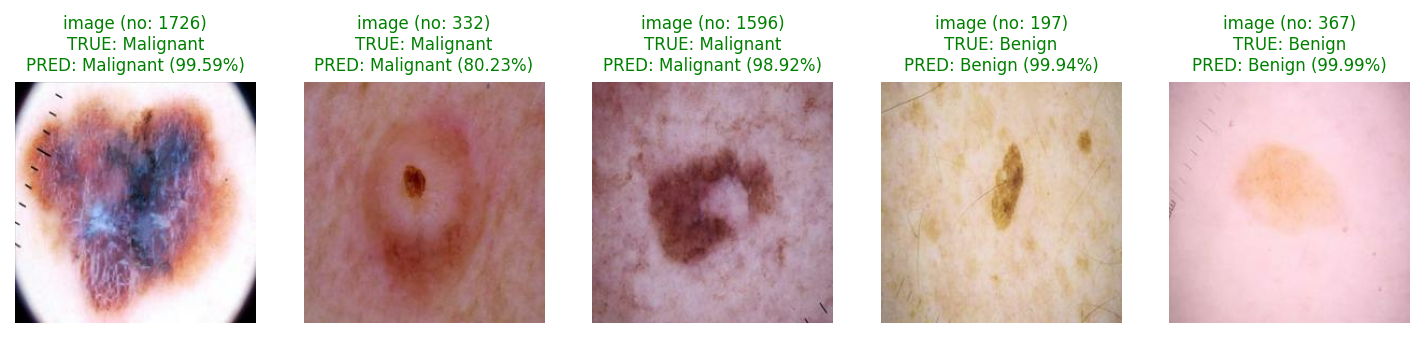

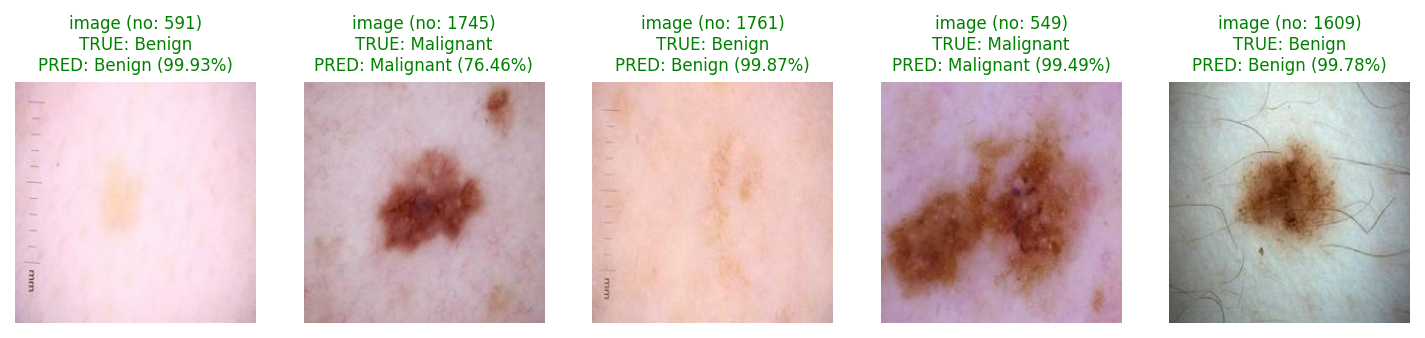

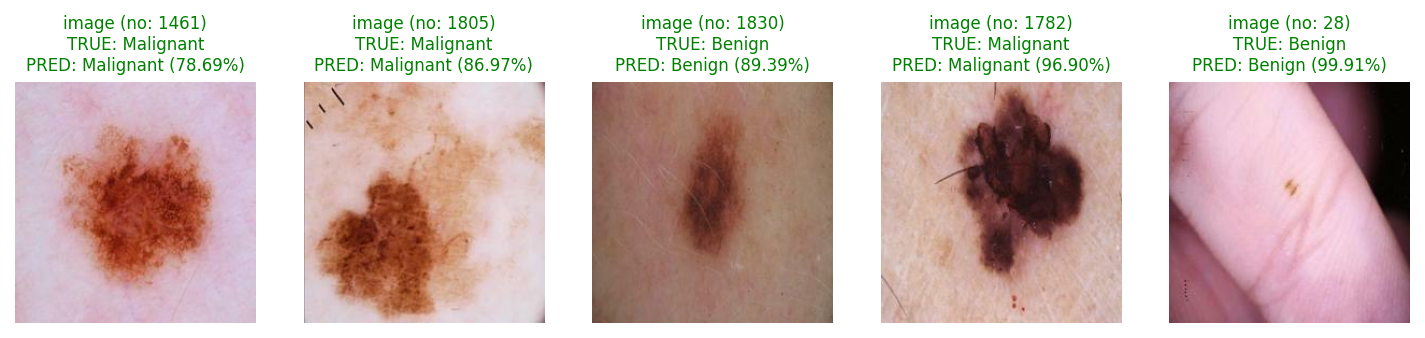

In [25]:
# Red title -> a false prediction
# Green title -> a true prediction

random_test_sample_with_prediction(21)
random_test_sample_with_prediction(204)
random_test_sample_with_prediction(293)

In [26]:
loaded_model = tf.keras.models.load_model('/kaggle/working/my_model.tf')

1/1 [==============================] - 2s 2s/step


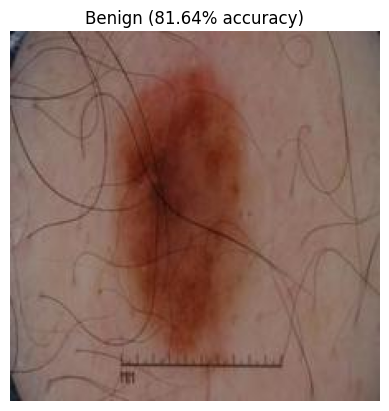

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# 5742
test_image_path = '/kaggle/input/melanoma-cancer-dataset/test/Malignant/5742.jpg'

test_image = cv2.imread(test_image_path)
test_image = cv2.resize(test_image, (224, 224))
test_image_display = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image_normalized = test_image / 255.0
test_image_normalized = np.expand_dims(test_image_normalized, axis=0)

predictions = loaded_model.predict(test_image_normalized)
predicted_class_index = np.argmax(predictions)
if predicted_class_index == 0:
    predicted_class = 'Benign'
else:
    predicted_class = 'Malignant'

predicted_accuracy = np.max(predictions) *100

# if predicted_class_index == 1:
#     bounding_box = [50, 70, 150, 120]
#     cv2.rectangle(test_image_display, (bounding_box[0], bounding_box[1]), (bounding_box[2], bounding_box[3]), (0, 255, 0), 2)

plt.imshow(test_image_display)
plt.title(f"{predicted_class} ({predicted_accuracy:.2f}% accuracy)")
plt.axis('off')
plt.show()